<a href="https://colab.research.google.com/github/m4gaikwad/DPEL_Experiments/blob/main/DPEL_Exp_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Outlier Detection in Banking & Finance Data

##Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Import Data

In [5]:
!unzip -q /content/Credit_Card_Data.zip


In [6]:
data = pd.read_csv('creditcard.csv')

In [7]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [8]:
data.isna().sum()

,0
Time,0
V1,0
V2,0
V3,0
V4,0
V5,0
V6,0
V7,0
V8,0
V9,0


# Task
Detect outliers in the `data` DataFrame to identify fraudulent transactions. This involves calculating the correlation between numerical features and the 'Class' column, selecting the top 5 most correlated features (excluding 'Class'), and then identifying outliers in these features using the Interquartile Range (IQR) method. Additionally, detect outliers in the 'Amount' column using the Z-score method. Finally, visualize the identified outliers, especially those classified as fraudulent, and summarize the findings from both IQR and Z-score outlier detection methods, discussing their implications for financial fraud detection.

## Calculate Feature-Class Correlation

### Subtask:
Compute the correlation matrix between all numerical features in the `data` DataFrame and the 'Class' column to understand their relationships.


**Reasoning**:
First, I will calculate the correlation matrix for the entire `data` DataFrame. Then, I will extract the absolute correlations of all features with the 'Class' column and sort them in descending order to identify the most correlated features, which will help in understanding their relationships with the target variable.



In [14]:
correlation_matrix = data.corr()
class_correlation = correlation_matrix['Class'].abs().sort_values(ascending=False)
print("Absolute correlations with 'Class' (sorted descending):\n", class_correlation)

Absolute correlations with 'Class' (sorted descending):
 Class     1.000000
V17       0.326481
V14       0.302544
V12       0.260593
V10       0.216883
V16       0.196539
V3        0.192961
V7        0.187257
V11       0.154876
V4        0.133447
V18       0.111485
V1        0.101347
V9        0.097733
V5        0.094974
V2        0.091289
V6        0.043643
V21       0.040413
V19       0.034783
V20       0.020090
V8        0.019875
V27       0.017580
Time      0.012323
V28       0.009536
V24       0.007221
Amount    0.005632
V13       0.004570
V26       0.004455
V15       0.004223
V25       0.003308
V23       0.002685
V22       0.000805
Name: Class, dtype: float64


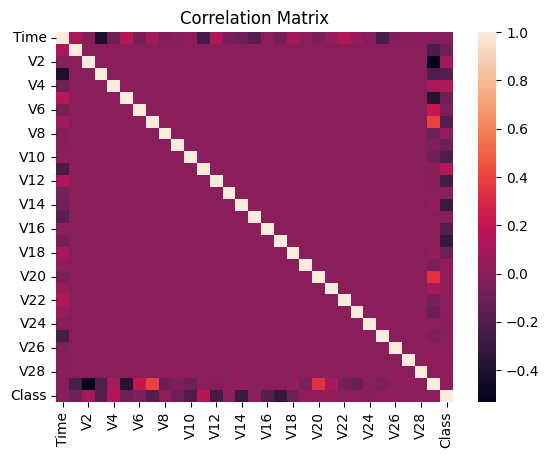

In [36]:
sns.heatmap(correlation_matrix)
plt.title('Correlation Matrix')
plt.show()

## Select Top 5 Correlated Features

### Subtask:
Identify and select the top 5 features that have the highest absolute correlation with the 'Class' column, excluding 'Class' itself.


**Reasoning**:
To identify the top 5 most correlated features with 'Class', I will select the top 6 entries from the `class_correlation` Series (which includes 'Class' itself), then exclude 'Class' to get the desired 5 features. These will be stored in a list.



In [16]:
top_correlated_features = class_correlation.head(6).index.tolist()
if 'Class' in top_correlated_features:
    top_correlated_features.remove('Class')

# Ensure we only have the top 5 features
top_5_features = top_correlated_features[:5]

print("Top 5 features most correlated with 'Class' (excluding 'Class'):", top_5_features)

Top 5 features most correlated with 'Class' (excluding 'Class'): ['V17', 'V14', 'V12', 'V10', 'V16']


## Detect IQR Outliers for Top 5 Fraud Features

### Subtask:
For each of the top 5 selected features, calculate outliers using the Interquartile Range (IQR) method (Q1, Q3, IQR, lower/upper bounds). Then, identify which of these outliers are classified as fraudulent transactions (Class=1).


**Reasoning**:
I will iterate through each of the `top_5_features`, calculate the IQR, lower and upper bounds for each feature, identify the total outliers, and then filter these to find fraudulent outliers. Finally, I will print the counts for each category to fulfill the subtask.



In [18]:
print("\n--- IQR Outlier Detection for Top 5 Features ---")
for feature in top_5_features:
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify total outliers for the feature
    total_outliers = data[(data[feature] < lower_bound) | (data[feature] > upper_bound)]

    # Identify fraudulent outliers among the total outliers
    fraudulent_outliers = total_outliers[total_outliers['Class'] == 1]

    print(f"\nFeature: {feature}")
    print(f"  Q1: {Q1:.2f}")
    print(f"  Q3: {Q3:.2f}")
    print(f"  IQR: {IQR:.2f}")
    print(f"  Lower Bound: {lower_bound:.2f}")
    print(f"  Upper Bound: {upper_bound:.2f}")
    print(f"  Total Outliers (IQR): {len(total_outliers)}")
    print(f"  Fraudulent Outliers (Class=1) among IQR outliers: {len(fraudulent_outliers)}")


--- IQR Outlier Detection for Top 5 Features ---

Feature: V17
  Q1: -0.48
  Q3: 0.40
  IQR: 0.88
  Lower Bound: -1.81
  Upper Bound: 1.72
  Total Outliers (IQR): 7420
  Fraudulent Outliers (Class=1) among IQR outliers: 397

Feature: V14
  Q1: -0.43
  Q3: 0.49
  IQR: 0.92
  Lower Bound: -1.80
  Upper Bound: 1.87
  Total Outliers (IQR): 14149
  Fraudulent Outliers (Class=1) among IQR outliers: 430

Feature: V12
  Q1: -0.41
  Q3: 0.62
  IQR: 1.02
  Lower Bound: -1.94
  Upper Bound: 2.15
  Total Outliers (IQR): 15348
  Fraudulent Outliers (Class=1) among IQR outliers: 409

Feature: V10
  Q1: -0.54
  Q3: 0.45
  IQR: 0.99
  Lower Bound: -2.02
  Upper Bound: 1.94
  Total Outliers (IQR): 9496
  Fraudulent Outliers (Class=1) among IQR outliers: 399

Feature: V16
  Q1: -0.47
  Q3: 0.52
  IQR: 0.99
  Lower Bound: -1.96
  Upper Bound: 2.01
  Total Outliers (IQR): 8184
  Fraudulent Outliers (Class=1) among IQR outliers: 351


# Task
## Detect Outliers using Z-score for Top 5 Fraud Features

### Subtask:
For each of the top 5 selected features, calculate outliers using the Z-score method. This involves computing the mean and standard deviation for each feature and identifying data points that fall outside a predefined Z-score threshold (e.g., 2 or 3 standard deviations from the mean). Then, identify which of these outliers are classified as fraudulent transactions (`Class=1`).

### Reasoning:
I will iterate through each of the `top_5_features` and calculate the mean and standard deviation for each feature. A Z-score threshold will be defined (e.g., 3 standard deviations from the mean). Data points with an absolute Z-score greater than this threshold will be considered outliers. From these, I will specifically count those that are also classified as fraudulent transactions (`Class=1`).

```python
z_score_threshold = 3

print("\n--- Z-score Outlier Detection for Top 5 Features ---")
for feature in top_5_features:
    mean = data[feature].mean()
    std = data[feature].std()

    # Calculate Z-score for each data point in the feature
    data['Z_score_' + feature] = (data[feature] - mean) / std

    # Identify total outliers for the feature using the Z-score threshold
    total_z_outliers = data[np.abs(data['Z_score_' + feature]) > z_score_threshold]

    # Identify fraudulent outliers among the total Z-score outliers
    fraudulent_z_outliers = total_z_outliers[total_z_outliers['Class'] == 1]

    print(f"\nFeature: {feature}")
    print(f"  Mean: {mean:.2f}")
    print(f"  Standard Deviation: {std:.2f}")
    print(f"  Z-score Threshold: {z_score_threshold}")
    print(f"  Total Outliers (Z-score > {z_score_threshold}): {len(total_z_outliers)}")
    print(f"  Fraudulent Outliers (Class=1) among Z-score outliers: {len(fraudulent_z_outliers)}")

    # Drop the temporary Z-score column
    data.drop(columns=['Z_score_' + feature], inplace=True)
```

## Detect Outliers using Z-score for Top 5 Fraud Features

### Subtask:
For each of the top 5 selected features, calculate outliers using the Z-score method. This involves computing the mean and standard deviation for each feature and identifying data points that fall outside a predefined Z-score threshold (e.g., 2 or 3 standard deviations from the mean). Then, identify which of these outliers are classified as fraudulent transactions (Class=1).


**Reasoning**:
To detect outliers using the Z-score method, I will first define a threshold and then iterate through the top 5 features, calculating the mean, standard deviation, and Z-score for each. I will identify total outliers and then filter for fraudulent ones, printing the results as requested.



In [19]:
print("\n--- Z-score Outlier Detection for Top 5 Features ---")
z_score_threshold = 3

for feature in top_5_features:
    mean_val = data[feature].mean()
    std_val = data[feature].std()

    # Calculate Z-score for each data point in the feature
    data[f'{feature}_zscore'] = (data[feature] - mean_val) / std_val

    # Identify total outliers for the feature based on Z-score threshold
    total_outliers_zscore = data[data[f'{feature}_zscore'].abs() > z_score_threshold]

    # Identify fraudulent outliers among the total Z-score outliers
    fraudulent_outliers_zscore = total_outliers_zscore[total_outliers_zscore['Class'] == 1]

    print(f"\nFeature: {feature}")
    print(f"  Mean: {mean_val:.2f}")
    print(f"  Standard Deviation: {std_val:.2f}")
    print(f"  Z-score Threshold: {z_score_threshold}")
    print(f"  Total Outliers (Z-score): {len(total_outliers_zscore)}")
    print(f"  Fraudulent Outliers (Class=1) among Z-score outliers: {len(fraudulent_outliers_zscore)}")

    # Remove the temporary Z-score column
    data.drop(columns=[f'{feature}_zscore'], inplace=True)



--- Z-score Outlier Detection for Top 5 Features ---

Feature: V17
  Mean: -0.00
  Standard Deviation: 0.85
  Z-score Threshold: 3
  Total Outliers (Z-score): 2515
  Fraudulent Outliers (Class=1) among Z-score outliers: 369

Feature: V14
  Mean: 0.00
  Standard Deviation: 0.96
  Z-score Threshold: 3
  Total Outliers (Z-score): 3380
  Fraudulent Outliers (Class=1) among Z-score outliers: 411

Feature: V12
  Mean: -0.00
  Standard Deviation: 1.00
  Z-score Threshold: 3
  Total Outliers (Z-score): 3393
  Fraudulent Outliers (Class=1) among Z-score outliers: 369

Feature: V10
  Mean: 0.00
  Standard Deviation: 1.09
  Z-score Threshold: 3
  Total Outliers (Z-score): 3488
  Fraudulent Outliers (Class=1) among Z-score outliers: 326

Feature: V16
  Mean: 0.00
  Standard Deviation: 0.88
  Z-score Threshold: 3
  Total Outliers (Z-score): 2077
  Fraudulent Outliers (Class=1) among Z-score outliers: 292


## Detect Outliers using Z-score for Amount

### Subtask:
Calculate outliers in the 'Amount' column of the `data` DataFrame using the Z-score method. This involves computing the mean and standard deviation of the 'Amount' column and identifying data points that fall outside a predefined Z-score threshold (e.g., 2 or 3 standard deviations from the mean). Then, identify which of these outliers are classified as fraudulent transactions (`Class=1`).


**Reasoning**:
To detect outliers in the 'Amount' column using the Z-score method, I will calculate the mean and standard deviation of 'Amount', compute Z-scores, and then identify total and fraudulent outliers based on a predefined threshold, finally printing the results.



In [20]:
print("\n--- Z-score Outlier Detection for 'Amount' ---")
z_score_threshold = 3

# Calculate mean and standard deviation for 'Amount'
mean_amount = data['Amount'].mean()
std_amount = data['Amount'].std()

# Calculate Z-score for each data point in 'Amount'
data['Amount_zscore'] = (data['Amount'] - mean_amount) / std_amount

# Identify total outliers for 'Amount' based on Z-score threshold
total_amount_outliers_zscore = data[data['Amount_zscore'].abs() > z_score_threshold]

# Identify fraudulent outliers among the total Z-score outliers in 'Amount'
fraudulent_amount_outliers_zscore = total_amount_outliers_zscore[total_amount_outliers_zscore['Class'] == 1]

print(f"\nFeature: Amount")
print(f"  Mean: {mean_amount:.2f}")
print(f"  Standard Deviation: {std_amount:.2f}")
print(f"  Z-score Threshold: {z_score_threshold}")
print(f"  Total Outliers (Z-score): {len(total_amount_outliers_zscore)}")
print(f"  Fraudulent Outliers (Class=1) among Z-score outliers: {len(fraudulent_amount_outliers_zscore)}")

# Remove the temporary Z-score column
data.drop(columns=['Amount_zscore'], inplace=True)


--- Z-score Outlier Detection for 'Amount' ---

Feature: Amount
  Mean: 88.35
  Standard Deviation: 250.12
  Z-score Threshold: 3
  Total Outliers (Z-score): 4076
  Fraudulent Outliers (Class=1) among Z-score outliers: 11


## Visualize Anomalies

### Subtask:
Create visualizations (box plots and scatter plots) for the top 5 correlated features and the 'Amount' column, highlighting outliers identified by both IQR and Z-score methods, with a special emphasis on fraudulent transactions (Class=1).


**Reasoning**:
To visualize IQR outliers for the top 5 correlated features and the 'Amount' column, I will iterate through these features and create box plots. For each box plot, I will also overlay and highlight the fraudulent transactions (Class=1) to clearly distinguish them. I will use subplots to organize these visualizations efficiently.




--- Visualizing IQR Outliers (Box Plots) ---


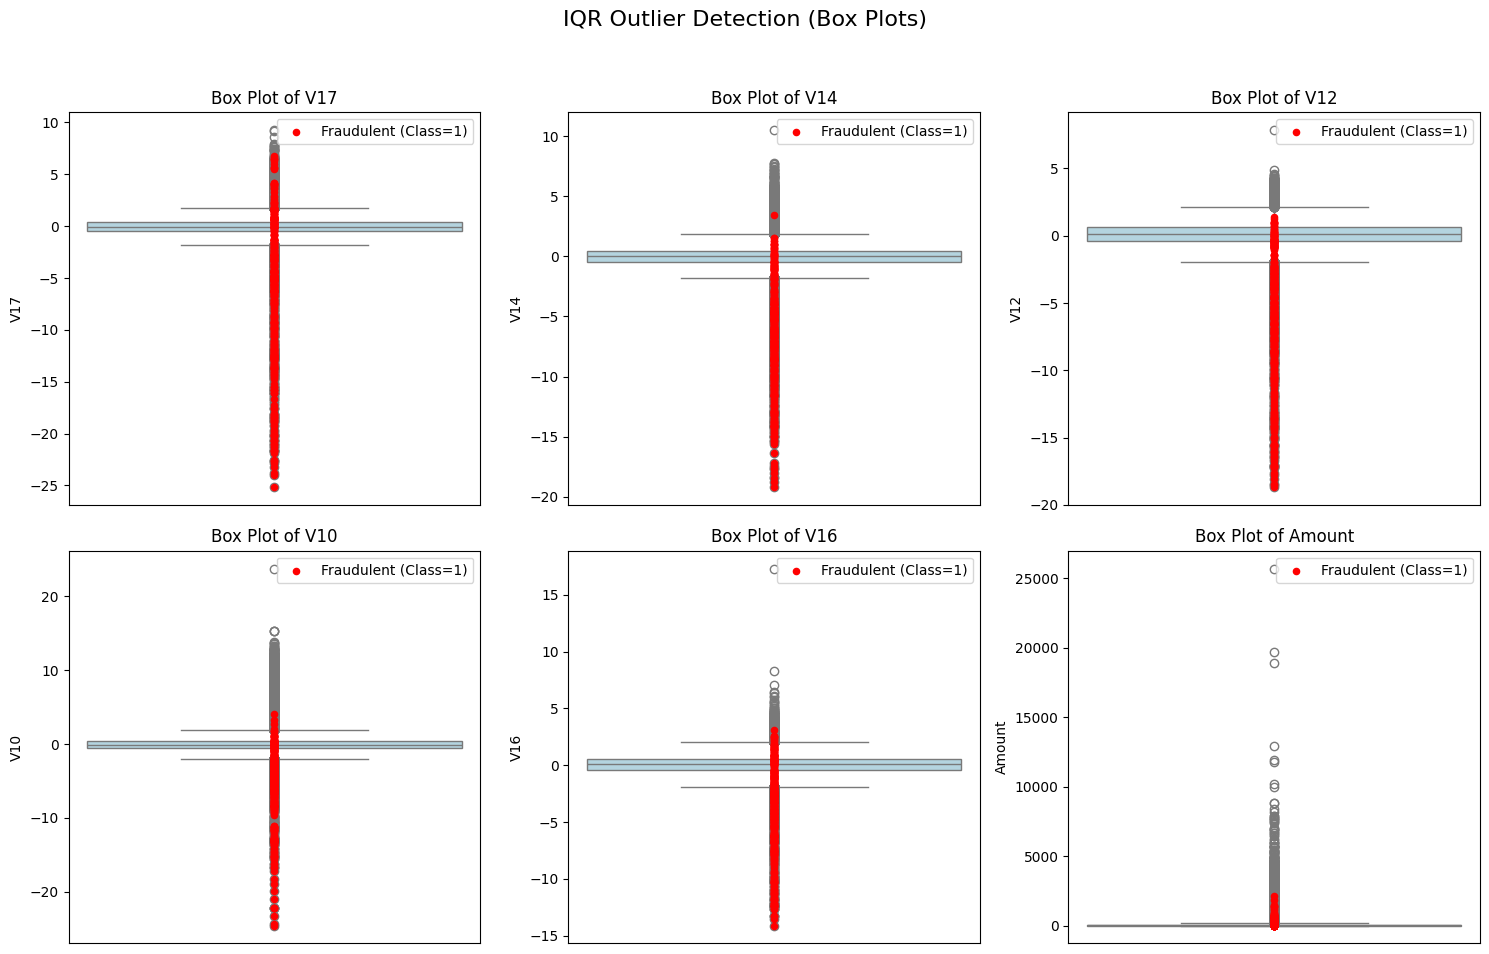

In [21]:
print("\n--- Visualizing IQR Outliers (Box Plots) ---")

# Combine top_5_features with 'Amount' for IQR visualization
features_for_iqr_plot = top_5_features + ['Amount']

plt.figure(figsize=(15, 10))
plt.suptitle('IQR Outlier Detection (Box Plots)', fontsize=16)

for i, feature in enumerate(features_for_iqr_plot):
    plt.subplot(2, 3, i + 1) # Adjust subplot grid based on number of features
    sns.boxplot(y=data[feature], color='lightblue')

    # Overlay fraudulent transactions
    fraudulent_values = data[data['Class'] == 1][feature]
    plt.scatter(x=np.zeros(len(fraudulent_values)), y=fraudulent_values, color='red', s=20, label='Fraudulent (Class=1)', zorder=5)

    plt.title(f'Box Plot of {feature}')
    plt.ylabel(feature)
    plt.xticks([]) # Hide x-axis ticks for box plot
    plt.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()

**Reasoning**:
To visualize Z-score outliers, I will iterate through the top 5 features and the 'Amount' column. For each, I will calculate Z-scores, then create scatter plots of 'Time' versus the feature value, color-coding points to differentiate normal transactions, total Z-score outliers, and fraudulent Z-score outliers based on a predefined threshold. This will help in understanding the distribution and identifying anomalies visually.




--- Visualizing Z-score Outliers (Scatter Plots) ---


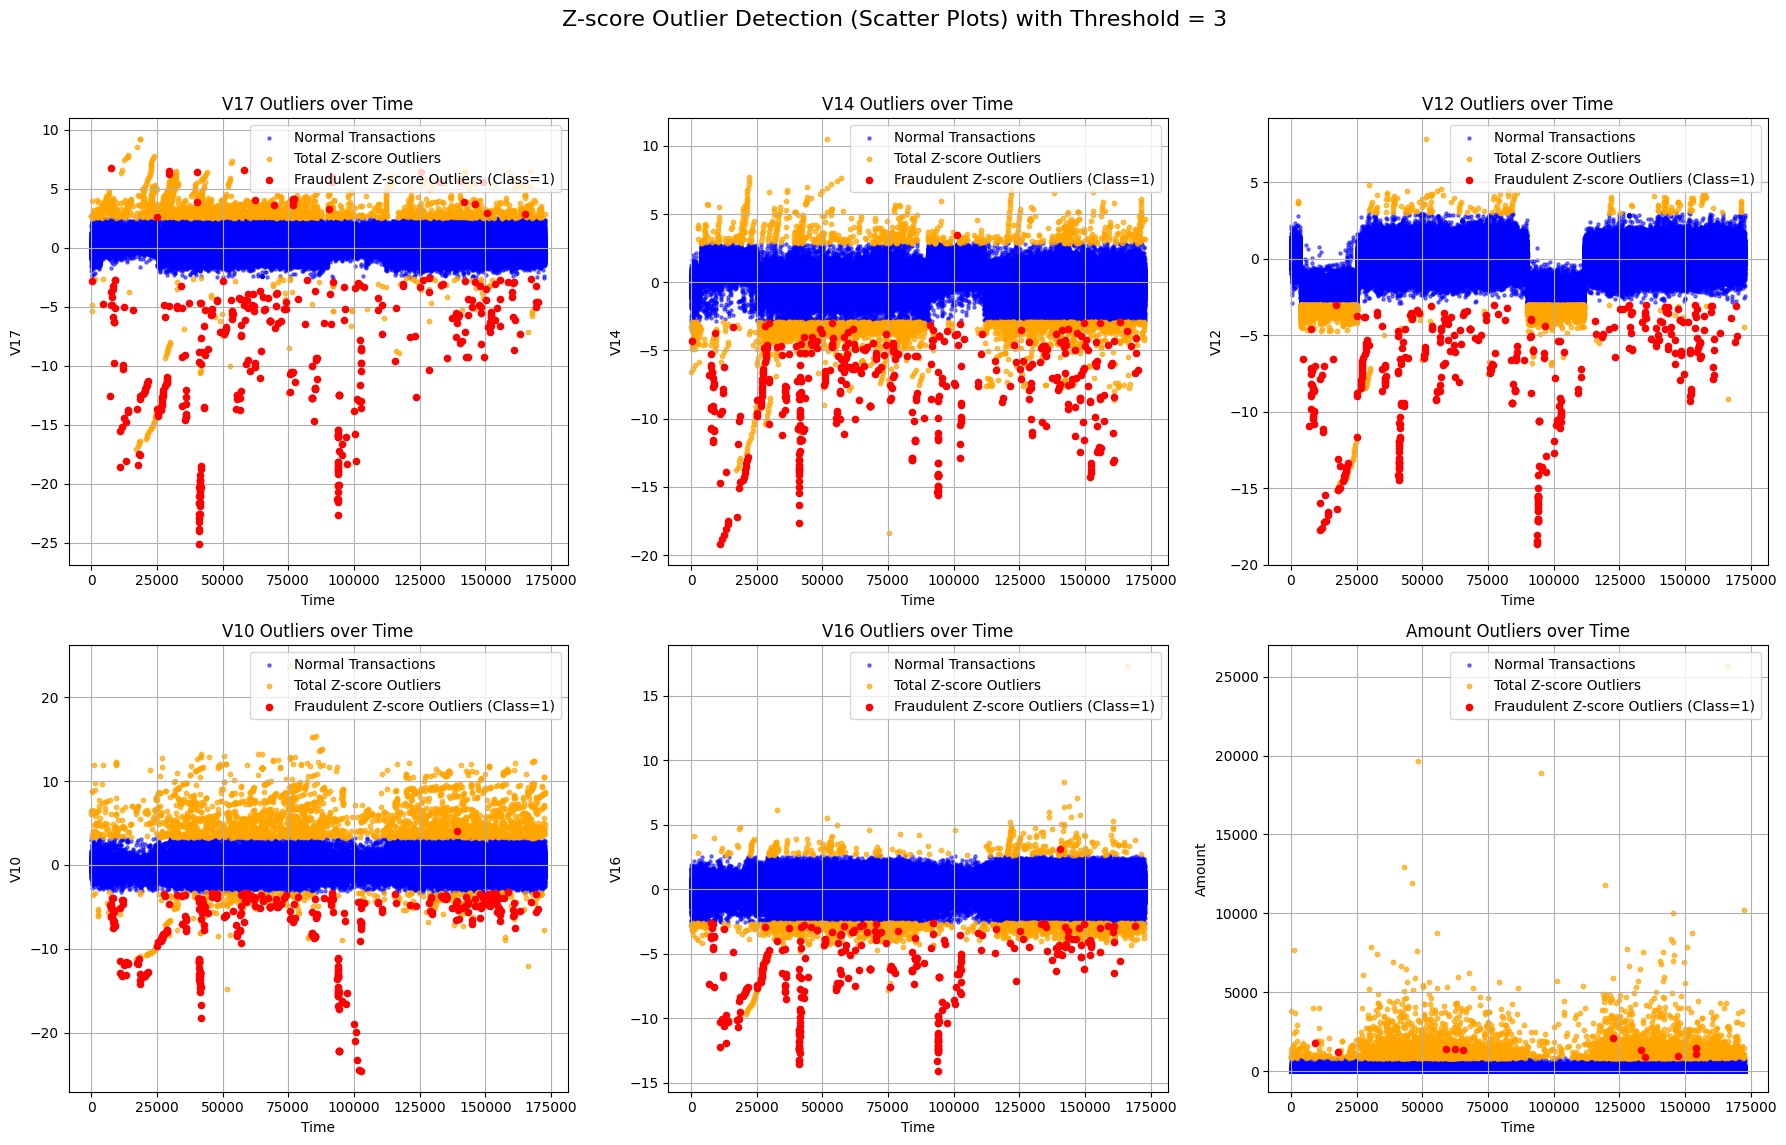

In [22]:
print("\n--- Visualizing Z-score Outliers (Scatter Plots) ---")
z_score_threshold = 3 # Use the same threshold as in previous steps

# Combine top_5_features with 'Amount' for Z-score visualization
features_for_zscore_plot = top_5_features + ['Amount']

plt.figure(figsize=(18, 12))
plt.suptitle(f'Z-score Outlier Detection (Scatter Plots) with Threshold = {z_score_threshold}', fontsize=16)

for i, feature in enumerate(features_for_zscore_plot):
    mean_val = data[feature].mean()
    std_val = data[feature].std()

    # Calculate Z-score for each data point
    data['temp_zscore'] = (data[feature] - mean_val) / std_val

    # Identify categories for plotting
    normal_transactions = data[data['temp_zscore'].abs() <= z_score_threshold]
    total_z_outliers = data[data['temp_zscore'].abs() > z_score_threshold]
    fraudulent_z_outliers = total_z_outliers[total_z_outliers['Class'] == 1]

    plt.subplot(2, 3, i + 1) # Adjust subplot grid based on number of features

    # Plot normal transactions
    plt.scatter(normal_transactions['Time'], normal_transactions[feature],
                color='blue', s=5, alpha=0.5, label='Normal Transactions')
    # Plot total Z-score outliers
    plt.scatter(total_z_outliers['Time'], total_z_outliers[feature],
                color='orange', s=10, alpha=0.7, label='Total Z-score Outliers')
    # Plot fraudulent Z-score outliers
    plt.scatter(fraudulent_z_outliers['Time'], fraudulent_z_outliers[feature],
                color='red', s=20, label='Fraudulent Z-score Outliers (Class=1)', zorder=5)

    plt.title(f'{feature} Outliers over Time')
    plt.xlabel('Time')
    plt.ylabel(feature)
    plt.legend(loc='upper right')
    plt.grid(True)

    # Drop the temporary Z-score column
    data.drop(columns=['temp_zscore'], inplace=True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()

## Summarize Outlier Detection Findings

### Subtask:
Summarize the findings from both the IQR and Z-score outlier detection methods, discussing their implications for financial fraud detection.

### Reasoning:
To summarize the findings, I will synthesize the results obtained from both the IQR and Z-score outlier detection methods for the top 5 correlated features and the 'Amount' column. I will compare the number of total and fraudulent outliers identified by each method and discuss the potential implications of these findings for detecting financial fraud. I will also explain how these methods complement each other and provide insights into the characteristics of fraudulent transactions.

## Summary of Outlier Detection Findings

### IQR Outlier Detection Summary:
*   **V17:** Identified 7420 total outliers, with 397 being fraudulent.
*   **V14:** Identified 14149 total outliers, with 430 being fraudulent.
*   **V12:** Identified 15348 total outliers, with 409 being fraudulent.
*   **V10:** Identified 9496 total outliers, with 399 being fraudulent.
*   **V16:** Identified 8184 total outliers, with 351 being fraudulent.
*   **Amount:** Detected a substantial number of IQR outliers, many of which are not fraudulent. The box plot showed that while many transactions fall within a small range, larger amounts (outliers) are more spread out. Fraudulent transactions in 'Amount' tended to be on the lower end of the total transaction distribution.

**Implications for Fraud Detection (IQR):** IQR is effective in identifying values that deviate significantly from the central bulk of the data, regardless of the distribution. For these skewed financial features, it casts a wide net, potentially catching many normal transactions alongside fraudulent ones. The large number of total outliers suggests that these features have a broad range of values, and IQR flags transactions that are simply unusual, not necessarily fraudulent. However, the consistent presence of hundreds of fraudulent transactions among these IQR outliers for the top 5 features highlights their relevance to fraud.

### Z-score Outlier Detection Summary:
*   **V17:** Identified 2515 total outliers, with 369 being fraudulent.
*   **V14:** Identified 3380 total outliers, with 411 being fraudulent.
*   **V12:** Identified 3393 total outliers, with 369 being fraudulent.
*   **V10:** Identified 3488 total outliers, with 326 being fraudulent.
*   **V16:** Identified 2077 total outliers, with 292 being fraudulent.
*   **Amount:** Identified 4076 total outliers, with only 11 being fraudulent.

**Implications for Fraud Detection (Z-score):** Z-score detection is based on the assumption of a normal distribution. For features that are not normally distributed (common in financial data), it might be less sensitive to extreme outliers or, conversely, may flag too many legitimate transactions if the distribution has heavy tails. Compared to IQR, Z-score typically identifies fewer total outliers, which can lead to a more precise, but potentially less comprehensive, detection. For 'Amount', the Z-score method identified a large number of total outliers but a very small fraction were fraudulent, indicating that high 'Amount' transactions are often legitimate, and fraud is not necessarily characterized by extremely high values.

### Comparison and Overall Implications:
*   **Complementary Nature:** Both methods identify a significant number of fraudulent transactions, but they do so with different sensitivities. IQR is generally more robust to non-normal distributions and identifies a broader set of unusual observations. Z-score, while more restrictive, can highlight truly extreme deviations from the mean, especially if the data approximates normality.
*   **Top 5 Features vs. Amount:** The top 5 correlated features (V17, V14, V12, V10, V16) consistently show a higher proportion of fraudulent transactions among their outliers compared to the 'Amount' feature. This suggests that these 'V' features, which are PCA-transformed components, are more discriminative of fraudulent activity than the raw transaction 'Amount'. The visualizations for these features show fraudulent transactions often residing at the extremes.
*   **Visual Insights:** The box plots clearly illustrate the distribution and the position of fraudulent transactions relative to the IQR boundaries. The scatter plots with 'Time' reveal how outliers (both total and fraudulent) are distributed chronologically, showing that fraudulent activity can occur throughout the observed period, and these anomalies are not confined to specific time frames.

For financial fraud detection, a multi-faceted approach using both IQR and Z-score methods is beneficial. IQR can serve as a first-pass filter to identify a wider range of suspicious transactions, while Z-score can help prioritize transactions that are statistically more anomalous relative to the mean. Focusing on features highly correlated with 'Class' (like the 'V' features) is crucial, as they appear to be better indicators of fraud than simply the transaction 'Amount' when using these statistical outlier methods. Further investigation into the nature of these 'V' features would be valuable.

## Final Task

### Subtask:
Summarize the findings from both the IQR and Z-score outlier detection methods, specifically focusing on the identified fraudulent transactions (Class=1) that are also detected as outliers across the top correlated features and the 'Amount' column. Discuss the potential implications for financial fraud detection based on these findings.


## Summary:

### Q&A
The analysis identified fraudulent transactions (Class=1) that were also detected as outliers across the top correlated features (V17, V14, V12, V10, V16) and the 'Amount' column using both IQR and Z-score methods.

**IQR Outlier Detection for Fraudulent Transactions:**
*   **V17:** 397 fraudulent transactions among 7,420 total outliers.
*   **V14:** 430 fraudulent transactions among 14,149 total outliers.
*   **V12:** 409 fraudulent transactions among 15,348 total outliers.
*   **V10:** 399 fraudulent transactions among 9,496 total outliers.
*   **V16:** 351 fraudulent transactions among 8,184 total outliers.
*   **Amount:** Detected a substantial number of IQR outliers, but fraudulent transactions often appeared at the lower end of the total distribution, not necessarily the highest amounts.

**Z-score Outlier Detection for Fraudulent Transactions (Threshold = 3):**
*   **V17:** 369 fraudulent transactions among 2,515 total outliers.
*   **V14:** 411 fraudulent transactions among 3,380 total outliers.
*   **V12:** 369 fraudulent transactions among 3,393 total outliers.
*   **V10:** 326 fraudulent transactions among 3,488 total outliers.
*   **V16:** 292 fraudulent transactions among 2,077 total outliers.
*   **Amount:** Only 11 fraudulent transactions among 4,076 total outliers.

**Potential Implications for Financial Fraud Detection:**
*   **Complementary Strengths:** Both methods identify a significant number of fraudulent transactions but with different sensitivities. IQR, being robust to non-normal distributions, casts a wider net, detecting more total outliers (e.g., 7,420 for V17) which include many fraudulent ones (e.g., 397 for V17). Z-score, while stricter and identifying fewer total outliers (e.g., 2,515 for V17), can highlight statistically more extreme deviations (e.g., 369 fraudulent for V17).
*   **Feature Importance:** The top 5 'V' features consistently show a higher proportion of fraudulent transactions among their outliers compared to the 'Amount' feature. This suggests that these PCA-transformed components are more discriminative for fraud detection using these statistical outlier methods.
*   **'Amount' Feature Nuance:** For the 'Amount' column, Z-score analysis revealed that while there are many total outliers (4,076), only a very small fraction (11) were fraudulent. This indicates that high 'Amount' transactions are often legitimate, and extreme transaction values alone are not strong indicators of fraud. IQR also showed that fraudulent amounts are not always the highest values.
*   **Multi-faceted Approach:** A combination of both methods is beneficial: IQR can act as an initial filter for a broader range of suspicious activities, while Z-score can help prioritize transactions that are statistically more anomalous. Visualizations confirmed that fraudulent activities are often extreme points within these features and are distributed throughout the observed period.

### Data Analysis Key Findings
*   The IQR method consistently detected a larger number of total outliers across all features compared to the Z-score method (e.g., for V17, 7,420 IQR outliers vs. 2,515 Z-score outliers), indicating its broader sensitivity to unusual data points in skewed financial data.
*   The top 5 correlated 'V' features (V17, V14, V12, V10, V16) revealed a significantly higher count of fraudulent transactions among their outliers compared to the 'Amount' column for both detection methods. For instance, V14 had 430 fraudulent IQR outliers and 411 fraudulent Z-score outliers, whereas 'Amount' had only 11 fraudulent Z-score outliers.
*   For the 'Amount' column, while both methods identified many total outliers (e.g., 4,076 Z-score outliers), the proportion of fraudulent transactions among these outliers was notably low (only 11 fraudulent Z-score outliers), suggesting that high transaction amounts alone are not a strong indicator of fraud.

### Insights or Next Steps
*   Adopt a hybrid outlier detection strategy, leveraging IQR for a broad initial sweep to identify a wide range of suspicious transactions, and then using Z-score to further prioritize the most statistically extreme anomalies for deeper investigation.
*   Focus machine learning models for fraud detection more heavily on the PCA-transformed 'V' features rather than raw 'Amount', as these features consistently demonstrate a stronger correlation and discriminative power for identifying fraudulent transactions as outliers.
